In [1]:
!pip install mesa
!pip install numpy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que exista más de un agente por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime



MAXVAL = 10000

In [3]:
# Nombre: Diego Reséndiz Fernánde
#Matricula: A01708017
#Fecha de creacion: 15/05/2024
#Ultima fecha de modificación: 15/05/2024
#Sinopsis:
#Programa que simula una situacion en donde robots limpiadores se dejan en un area de NXN casillas, casillas que estan sucias dependiendo de un porcentaje sacado al azar
#El programa simula la limpieza de dicho espacio en donde los robots se mueven aleatoriamente para limpiar las casillas en las que se encuentren para obtener el mayor porcentaje de casillas limpias.

In [4]:
#Nombre: AgenteAspiradora
#Parametros: Ninguno.
#Return: Nada
#Se encarga de servir como base para crear agentes de tipo aspiradora
class AgenteAspiradora(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)
    self.totalMoves = 0
#Nombre: Move
#Parametros: Ninguno.
#Return: Nada
#Se encarga de mover el agente en una de las 8 direcciones de manera aleatoria y además lleva la cuenta de cuantos movimientos ha hecho el agente de manera individual
  def move(self):
    options=self.model.grid.get_neighborhood(self.pos,moore = True, include_center=False)
    self.model.grid.move_agent(self,self.random.choice(options))
    self.totalMoves= self.totalMoves + 1

#Nombre: clean
#Parametros: Ninguno.
#Return: Nada
#Se encarga de limpiar la celda en la que está el agente actualmente
  def clean(self):
    if self.model.cells[self.pos[0]] [self.pos[1]] == 1:
      self.model.cells[self.pos[0]] [self.pos[1]] = 0

#Nombre: Step
#Parametros: Ninguno.
#Return: Nada
#Se encarga de que en cada paso que se de en la simulacion, se ejecuten las acciones dentro.
  def step(self):
    self.clean()
    self.move()


In [5]:
#Nombre: getGrid
#Parametros: un model.
#Return: Nada
#Se encarga de crear una representación visual del estado actual de la cuadrícula en el modelo
def getGrid(model):
    grid=np.zeros( (model.grid.width, model.grid.height))
    for x in range(model.grid.width):
      for y in range(model.grid.height):
        grid[x][y] = model.cells[x][y]
        if not model.grid.is_cell_empty((x,y)):
          grid[x][y] = 2
        else:
          grid[x][y] = model.cells[x][y]
    return grid


In [6]:
#Nombre: AspiradoraModel
#Parametros: Ninguno.
#Return: Nada
#Se encarga de servir como base para crear la simulación que contiene los agentes
class AspiradoraModel(Model):
  def __init__(self, width, height, numAgents=1, maxSteps=100, dirtyCellsPercentage = np.random.random()):
    super().__init__()


    self.numAgents = numAgents
    self.dirtyCellsPercentage = dirtyCellsPercentage
    self.grid = MultiGrid(width, height, False)
    self.schedule = RandomActivation(self)
    self.dataCollector = DataCollector(model_reporters = {"Grid" : getGrid })
    self.cells = np.zeros((width, height))
    self.visitedCells = np.zeros((width, height))
    self.maxSteps = maxSteps
    self.currentStep = 0
    self.timeNeeded = None
    self.cleanPercentage = None
    self.totalMoves = None
    #Calculamos el numero de celdas que deben estar sucias y cambiamos su valor (1 ó 0), es decir, las ensuciamos de manera aleatoria.
    amount = int ( (width * height) * self.dirtyCellsPercentage)
    for i in range(amount):
      finished = False
      while not finished:
        x = int (np.random.random() * MAXVAL) % width
        y = int (np.random.random() * MAXVAL) % height
        if self.cells[x][y] == 0:
          self.cells[x][y] = 1
        if self.visitedCells[x][y] == False:
          self.visitedCells[x][y] = True
          finished = True
#Instanciamos los agentes requeridos y los colocamos en la casilla (1,1)
    for i in range(numAgents):
      agent = AgenteAspiradora(i, self)
      self.grid.place_agent(agent, (1,1))
      self.schedule.add(agent)

#Nombre: AllClean
#Parametros: Ninguno.
#Return: Nada
#Se encarga de servir como bandera para determinar que todas las celdas estan limpias
  def allClean(self):
    return np.all(self.cells == 0)

#Nombre: Step
#Parametros: Ninguno.
#Return: Nada
#Se encarga de que en cada paso que se de en la simulacion, se ejecuten las acciones dentro.
  def step(self):
    self.dataCollector.collect(self)
    self.schedule.step()
    self.currentStep += 1
    if self.currentStep >= self.maxSteps or self.allClean():
      self.timeNeeded = self.currentStep
      self.cleanPercentage = (np.count_nonzero(self.cells == 0) / (self.grid.width * self.grid.height)) * 100
      self.totalMoves = sum(agent.totalMoves for agent in self.schedule.agents)
      self.running = False



In [7]:

#Se encarga de llevar acabo las iteraciones, es decir el step, es donde se lleva acabo la simlacion
GRID_SIZE = 20

MAX_ITER = 100

AGENT_NUM= 20

startTime = time.time()

model = AspiradoraModel(GRID_SIZE, GRID_SIZE, AGENT_NUM, MAX_ITER)

i = 0
while i < MAX_ITER and not model.allClean():
  model.step()
  i = i + 1


In [8]:
#Obtenemos la informacion requerida para el analsis.
all_grid = model.dataCollector.get_model_vars_dataframe()

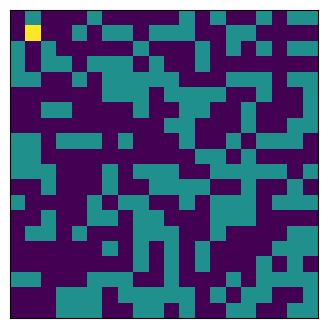

In [9]:
#Obtenemos la informacion en cada step y la graficamos para despues juntarla en una animacion
fig, axs=plt.subplots(figsize=(4,4))
axs.set_xticks([])
axs.set_yticks([])
patch =plt.imshow(all_grid.iloc[0][0], cmap=plt.colormaps['viridis'])

def animate(i):
  patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig,animate,frames = MAX_ITER)

In [10]:
#Llamamos la animacion
anim

In [12]:

#Despliege de los datos importantes.
totalTime = time.time() - startTime
print('Tiempo de ejecucion : %.5f segundos' % totalTime)
print(f'Tiempo necesario hasta que todas las celdas estén limpias: {model.timeNeeded} Steps')
print(f'Porcentaje de celdas limpias después del término de la simulación: {model.cleanPercentage}%')
print(f'Número de movimientos realizados por todos los agentes: {model.totalMoves}')

Tiempo de ejecucion : 26.99046 segundos
Tiempo necesario hasta que todas las celdas estén limpias: 100 Steps
Porcentaje de celdas limpias después del término de la simulación: 78.75%
Número de movimientos realizados por todos los agentes: 2000
